In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=64, shuffle=True)

In [4]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images)) # ToTensor()에 의해서 0~1 사이값이 됨 (나중에 decoder에서 최종적으로 다시 이 범위 값으로 변형해야 함)

tensor(0.) tensor(1.)


In [5]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 128), # N, 768 -> N, 128 (N : batch size)
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Linear(12, 3) # N, 3
      )

    self.decoder = nn.Sequential(
        nn.Linear(3, 12), # N, 3
        nn.ReLU(),
        nn.Linear(12, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28*28),
        nn.Sigmoid() # N, 784의 형태로, 최초 encoder 들어가기 전과 같은 0~1의 값으로
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [6]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [7]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
  for (img, _) in data_loader:
    img = img.reshape(-1, 28*28)
    # print(img.shape) : torch.Size([64, 784])
    recon = model(img)
    loss = criterion(recon, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
  outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0425
Epoch:2, Loss:0.0362
Epoch:3, Loss:0.0458
Epoch:4, Loss:0.0427
Epoch:5, Loss:0.0370
Epoch:6, Loss:0.0427
Epoch:7, Loss:0.0356
Epoch:8, Loss:0.0294
Epoch:9, Loss:0.0390
Epoch:10, Loss:0.0387


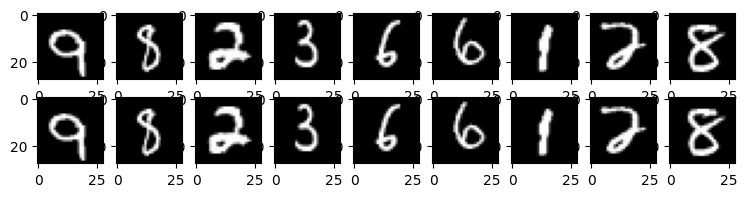

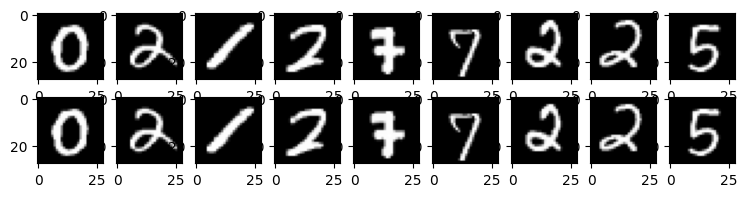

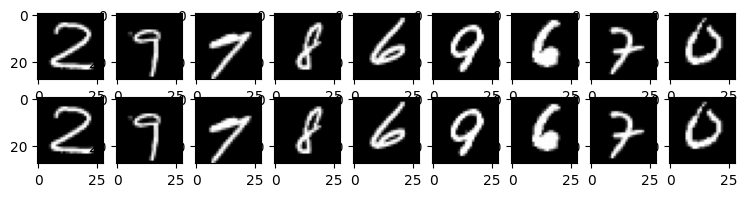

In [8]:
for k in range(0, num_epochs, 4):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs = outputs[k][1].detach().numpy() #torch tensor이므로 detach 후 numpy로 변환
  recon = outputs[k][2].detach().numpy()
  for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, i+1) # row_length+i
    item = item.reshape(-1, 28, 28)
    # print(item.shape) # item: 1, 28, 28
    plt.imshow(item[0])

  for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, 9+i+1) # row_length+i+1
    item = item.reshape(-1, 28, 28)
    # print(item.shape) # item: 1, 28, 28
    plt.imshow(item[0])


In [47]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [48]:
conv_model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(conv_model.parameters(), lr=1e-3, weight_decay=1e-5)

In [50]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0092
Epoch:2, Loss:0.0076
Epoch:3, Loss:0.0081
Epoch:4, Loss:0.0072
Epoch:5, Loss:0.0085
Epoch:6, Loss:0.0088
Epoch:7, Loss:0.0073
Epoch:8, Loss:0.0083
Epoch:9, Loss:0.0077
Epoch:10, Loss:0.0077


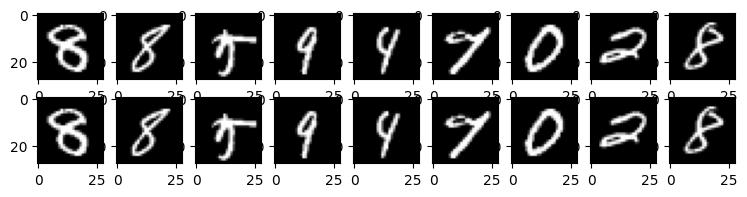

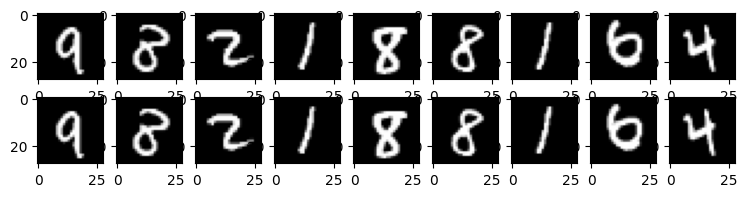

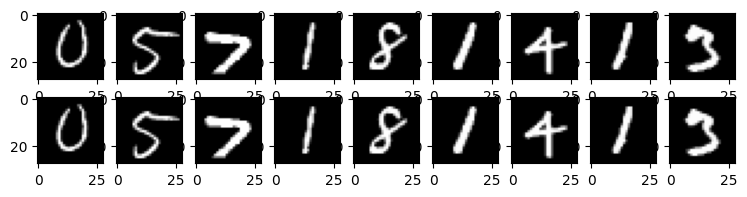

In [51]:
for k in range(0, num_epochs, 4):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs = outputs[k][1].detach().numpy() #torch tensor이므로 detach 후 numpy로 변환
  recon = outputs[k][2].detach().numpy()
  for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, i+1) # row_length+i
    item = item.reshape(-1, 28, 28)
    # print(item.shape) # item: 1, 28, 28
    plt.imshow(item[0])

  for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, 9+i+1) # row_length+i+1
    item = item.reshape(-1, 28, 28)
    # print(item.shape) # item: 1, 28, 28
    plt.imshow(item[0])
